# 1.Alignment of 3D models between adjacent time points

Since the coordinate positions of the samples in each period are not fixed, we need to align the samples of multiple periods in three dimensions, so that we can realize the four-dimensional level of spatiotemporal developmental analysis.

## Packages

In [1]:
import os
import sys
from pathlib import Path

import numpy as np

sys.path.insert(0, "/home/yao/PythonProject/Test_packages/dynamo-release")
sys.path.insert(0, "/home/yao/PythonProject/Yao_packages/spateo-release")
import dynamo as dyn
import spateo as st

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/home/yao/.local/lib/python3.8/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/home/yao/anaconda3/envs/BGIpy38_tf2/lib/python3.8/site-packages/spaghetti/network.py:36: Future

## Data source

In [3]:
# stage1: E7-9h
actual_stage1 = "E7-9h"
stage1_raw_adata = st.read_h5ad(f"{actual_stage1}_cellbin_tdr_v1.h5ad")
stage1_raw_embryo_pc = st.tdr.read_model(filename=f"{actual_stage1}_embryo_raw_pc_model.vtk")
stage1_raw_embryo_mesh = st.tdr.read_model(filename=f"{actual_stage1}_embryo_raw_mesh_model.vtk")

# stage2: E9-10h
actual_stage2 = "E9-10h"
stage2_adata = st.read_h5ad(f"{actual_stage2}_cellbin_tdr_v1.h5ad")
stage2_adata.obsm["before_3d_align_spatial"] = stage2_adata.obsm["tdr_spatial"]
stage2_adata.layers["log1p_X"] = np.log1p(stage2_adata.layers["counts_X"])

## Adjust the coordinates of the first model to the final desired coordinates

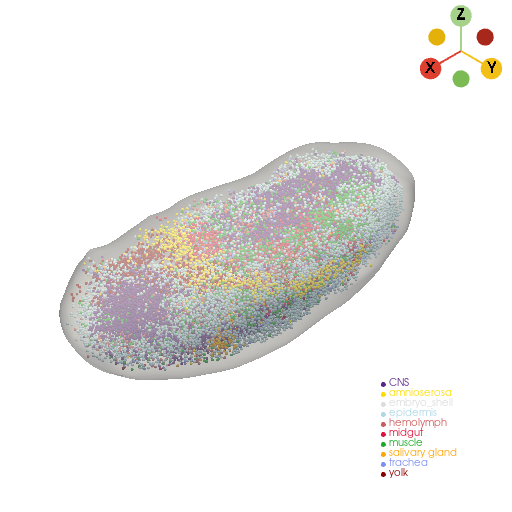

In [4]:
rotate_center = stage1_raw_embryo_pc.center
rotate_angle = (165, 0, -10)
rotate_embryo_pc = st.tdr.rotate_model(model=stage1_raw_embryo_pc, angle=rotate_angle, rotate_center=rotate_center, inplace=False)
rotate_embryo_mesh = st.tdr.rotate_model(model=stage1_raw_embryo_mesh, angle=rotate_angle, rotate_center=rotate_center, inplace=False)
st.pl.three_d_plot(
    model=st.tdr.collect_models([rotate_embryo_mesh, rotate_embryo_pc]),
    key=["tissue", "tissue"],
    model_style=["surface", "points"],
    model_size=[0, 3],
    jupyter="static",
)

In [5]:
stage1_adata = stage1_raw_adata[np.asarray(rotate_embryo_pc.point_data["obs_index"]), :].copy()
stage1_adata.layers["log1p_X"] = np.log1p(stage1_adata.layers["counts_X"])
# stage1_adata.uns["pp"] = {}
# dyn.pp.normalize_cell_expr_by_size_factors(adata=stage1_adata, layers="normalize_X", X_total_layers=True)
stage1_adata.obsm["before_3d_align_spatial"] = np.asarray(rotate_embryo_pc.points)
stage1_adata

AnnData object with n_obs × n_vars = 25857 × 8136
    obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
    uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial'
    obsm: 'align_spatial', 'bbox', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial', 'before_3d_align_spatial'
    layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced'

## Alignment of 3D models of two stages

In [6]:
align_samples, align_samples_ref = st.tl.models_align_ref(
    models=[stage1_adata, stage2_adata],
    models_ref=None,
    n_sampling=2000,
    sampling_method="trn",
    layer="log1p_X",
    spatial_key="before_3d_align_spatial",
    key_added="3d_align_spatial",
    device="0",
)
align_samples

|-----> [Running TRN] in progress: 100.0000%
|-----> [Running TRN] finished [378.3584s]
|-----> [Running TRN] in progress: 100.0000%
|-----> [Running TRN] finished [381.4986s]
|-----> [Models alignment] in progress: 100.0000%|-----------> Filtered all samples for common genes. There are 7890 common genes.
|-----> [Models alignment] in progress: 100.0000%
|-----> [Models alignment] finished [18.6270s]


[AnnData object with n_obs × n_vars = 25857 × 8136
     obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage'
     uns: 'PCs', '__type', 'auto_anno_result', 'dendrogram_anno_cell_type', 'dendrogram_anno_germ_layer', 'dendrogram_anno_tissue', 'explained_variance_ratio_', 'neighbors', 'pca_mean', 'pca_valid_ind', 'pearson_X_neighbors', 'rank_genes_groups', 'rank_genes_groups_anno_cell_type', 'rank_genes_groups_anno_germ_layer', 'rank_genes_groups_anno_tissue', 'scc', 'spatial', 'latter_models_align'
     obsm: 'align_spatial', 'bbox', 'contour', 'pearson_X_pca', 'pearson_X_umap', 'spatial', 'tdr_spatial', 'before_3d_align_spatial', '3d_align_spatial'
     layers: 'counts_X', 'log1p_X', 'pearson_X', 'spliced', 'unspliced',
 AnnData object with n_obs × n_vars = 24304 × 8484
     obs: 'area', 'slices', 'x', 'y', 'z', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 

In [7]:
stage1_aligned_adata_ref = align_samples_ref[0].copy()
stage2_aligned_adata_ref = align_samples_ref[1].copy()

stage1_aligned_adata = align_samples[0].copy()
stage2_aligned_adata = align_samples[1].copy()

## Generate aligned 3D models

### stage1 point cloud model

In [8]:
stage1_tissue_colormap = {
    "CNS": "#5A2686",
    "midgut": "#DC143C",
    "amnioserosa": "#FFDD00",
    "salivary gland": "#FFA500",

    "epidermis": "#ADD8E6",
    "muscle": "#1AAB27",
    "trachea": "#7F90F0",
    "hemolymph": "#CD5C5C",
    "yolk": "#8B0000",
}

stage1_raw_ref_pc = st.tdr.construct_pc(
    adata=stage1_aligned_adata_ref.copy(),
    spatial_key="before_3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage1_tissue_colormap,
)

stage1_aligned_ref_pc = st.tdr.construct_pc(
    adata=stage1_aligned_adata_ref.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage1_tissue_colormap,
)

stage1_raw_pc = st.tdr.construct_pc(
    adata=stage1_aligned_adata.copy(),
    spatial_key="before_3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage1_tissue_colormap,
)

stage1_aligned_pc = st.tdr.construct_pc(
    adata=stage1_aligned_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage1_tissue_colormap,
)

### stage2 point cloud model

In [9]:
stage2_tissue_colormap = {
    "CNS": "#5A2686",
    "midgut": "#DC143C",
    "amnioserosa": "#FFDD00",
    "salivary gland": "#FFA500",

    "epidermis": "#ADD8E6",
    "muscle": "#1AAB27",
    "trachea": "#7F90F0",
    "hemolymph": "#CD5C5C",
    "yolk": "#8B0000",
}

stage2_raw_ref_pc = st.tdr.construct_pc(
    adata=stage2_aligned_adata_ref.copy(),
    spatial_key="before_3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage2_tissue_colormap,
)

stage2_aligned_ref_pc = st.tdr.construct_pc(
    adata=stage2_aligned_adata_ref.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage2_tissue_colormap,
)

stage2_raw_pc = st.tdr.construct_pc(
    adata=stage2_aligned_adata.copy(),
    spatial_key="before_3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage2_tissue_colormap,
)

stage2_aligned_pc = st.tdr.construct_pc(
    adata=stage2_aligned_adata.copy(),
    spatial_key="3d_align_spatial",
    groupby="anno_tissue",
    key_added="tissue",
    colormap=stage2_tissue_colormap,
)

## Check that the alignment results at the overall level

### raw embryo model

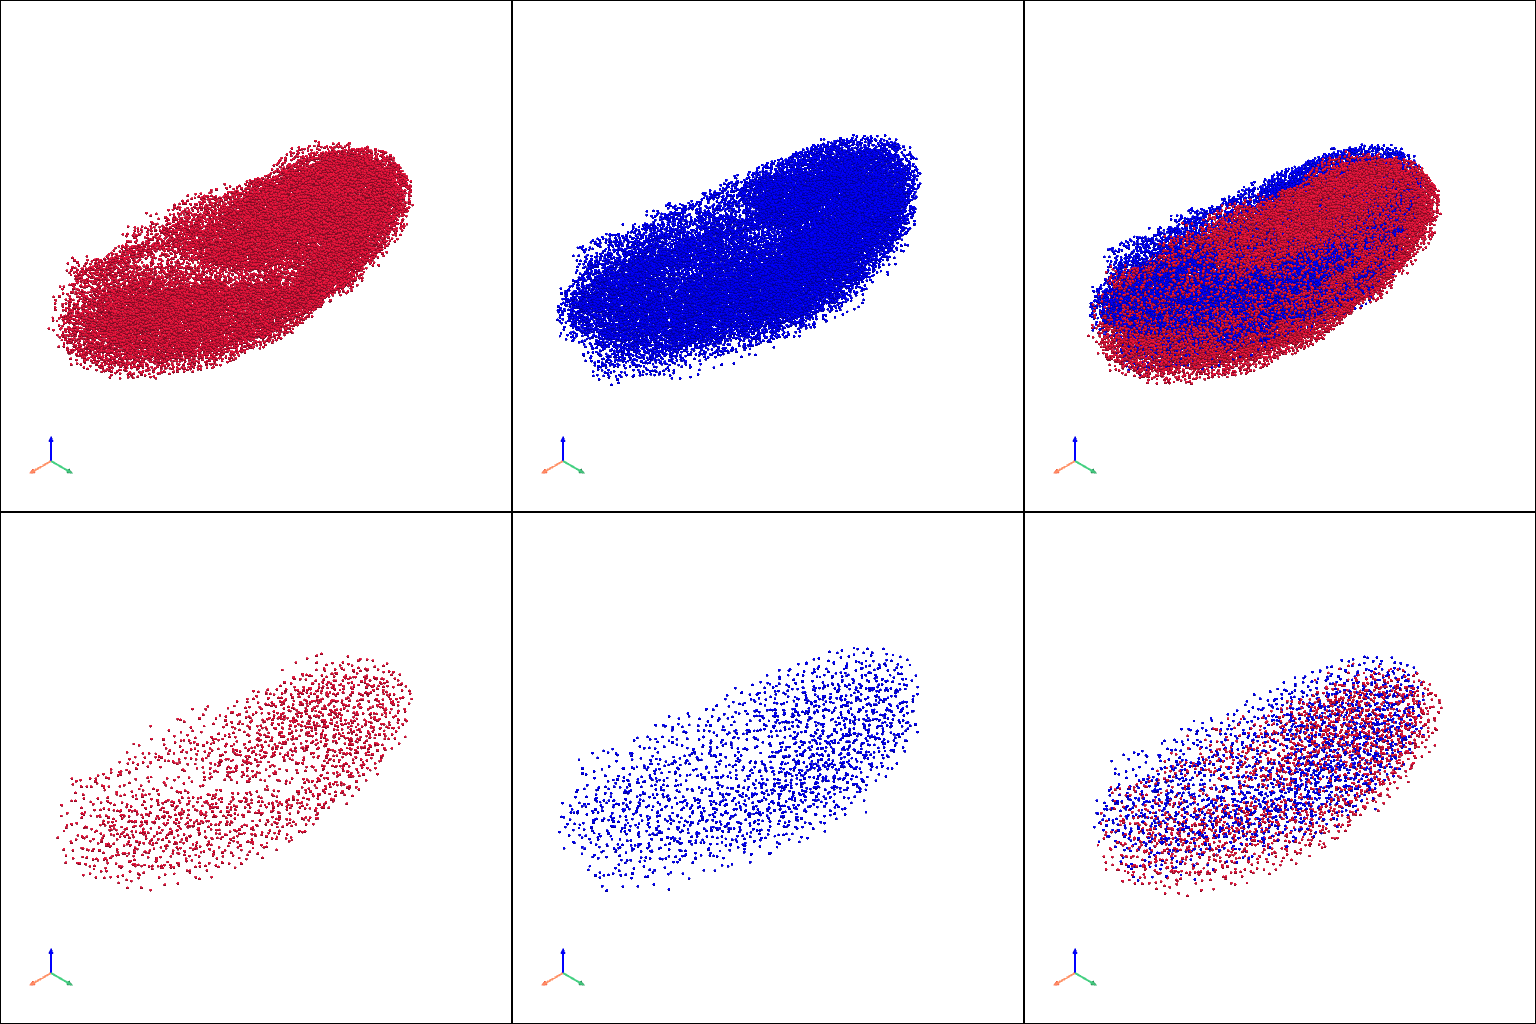

In [11]:
raw_pcs_v = [
    stage1_raw_pc.copy(), stage2_raw_pc.copy(), st.tdr.collect_models([stage1_raw_pc.copy(), stage2_raw_pc.copy()]),
    stage1_raw_ref_pc.copy(), stage2_raw_ref_pc.copy(), st.tdr.collect_models([stage1_raw_ref_pc.copy(), stage2_raw_ref_pc.copy()])
]

st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(raw_pcs_v),
    colormap=["#DC143C", "#0000FF", ["#DC143C", "#0000FF"], "#DC143C", "#0000FF", ["#DC143C", "#0000FF"]],
    model_style="points",
    model_size=3,
    off_screen=False,
    shape=(2, 3),
    window_size=(512*3, 512*2),
    show_legend=False,
    jupyter="static",
)

### aligned embryo model

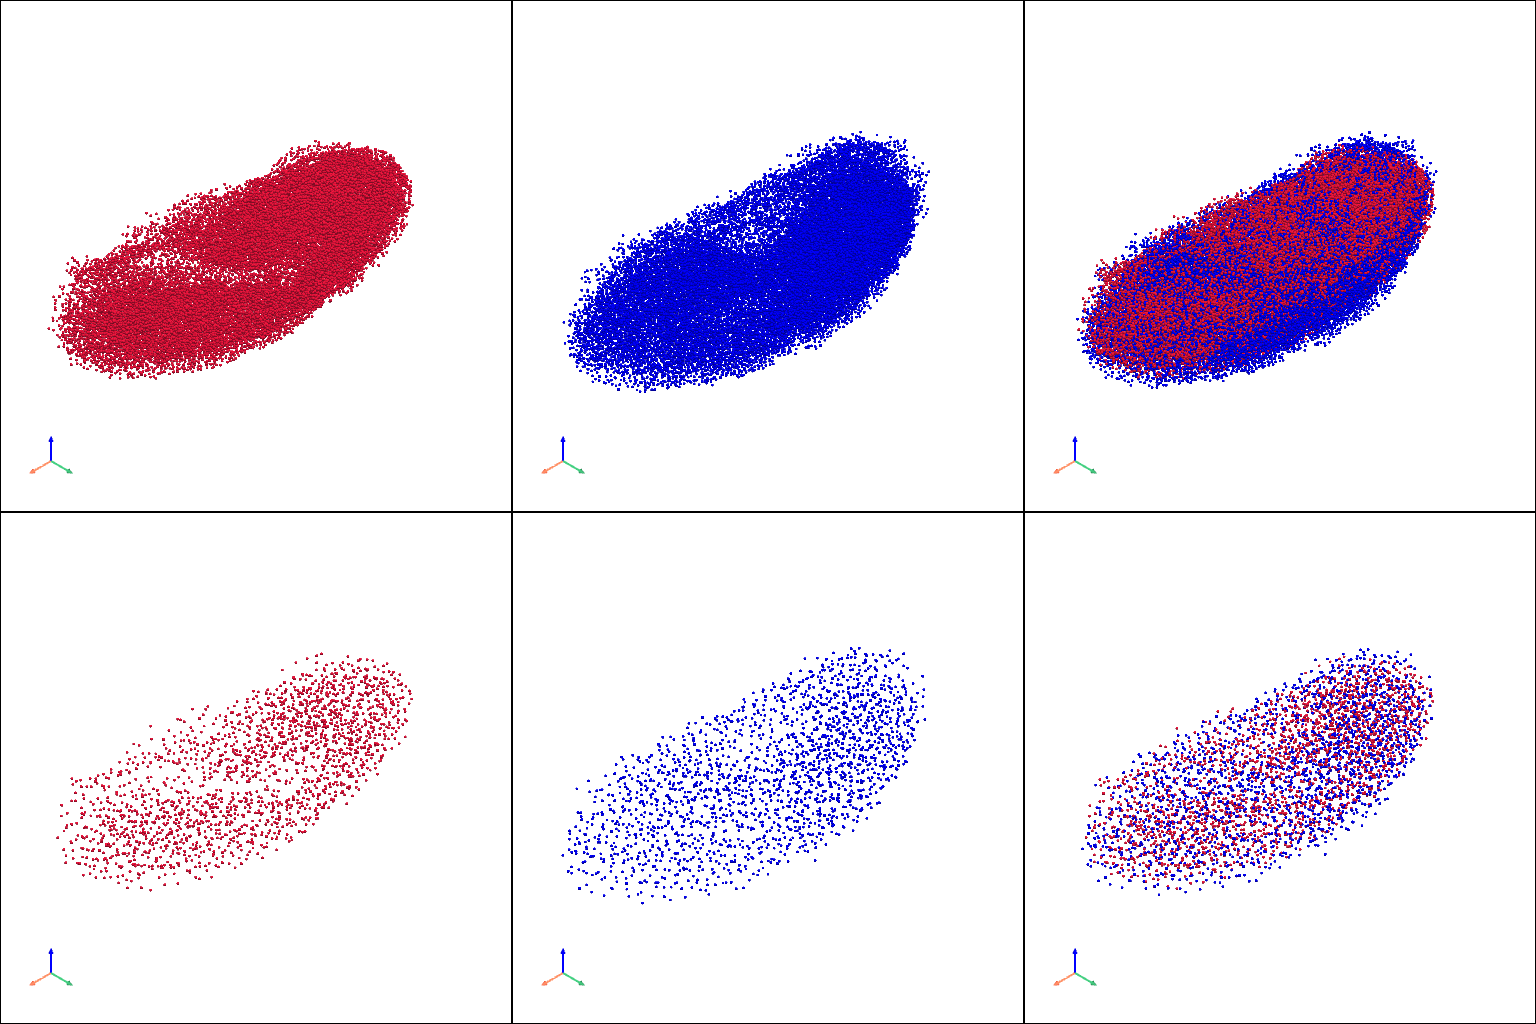

In [12]:
aligned_pcs_v = [
    stage1_aligned_pc.copy(), stage2_aligned_pc.copy(), st.tdr.collect_models([stage1_aligned_pc.copy(), stage2_aligned_pc.copy()]),
    stage1_aligned_ref_pc.copy(), stage2_aligned_ref_pc.copy(), st.tdr.collect_models([stage1_aligned_ref_pc.copy(), stage2_aligned_ref_pc.copy()])
]

st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(aligned_pcs_v),
    colormap=["#DC143C", "#0000FF", ["#DC143C", "#0000FF"], "#DC143C", "#0000FF", ["#DC143C", "#0000FF"]],
    model_style="points",
    model_size=3,
    off_screen=False,
    shape=(2, 3),
    window_size=(512*3, 512*2),
    show_legend=False,
    jupyter="static",
)

### aligned embryo models with CNS

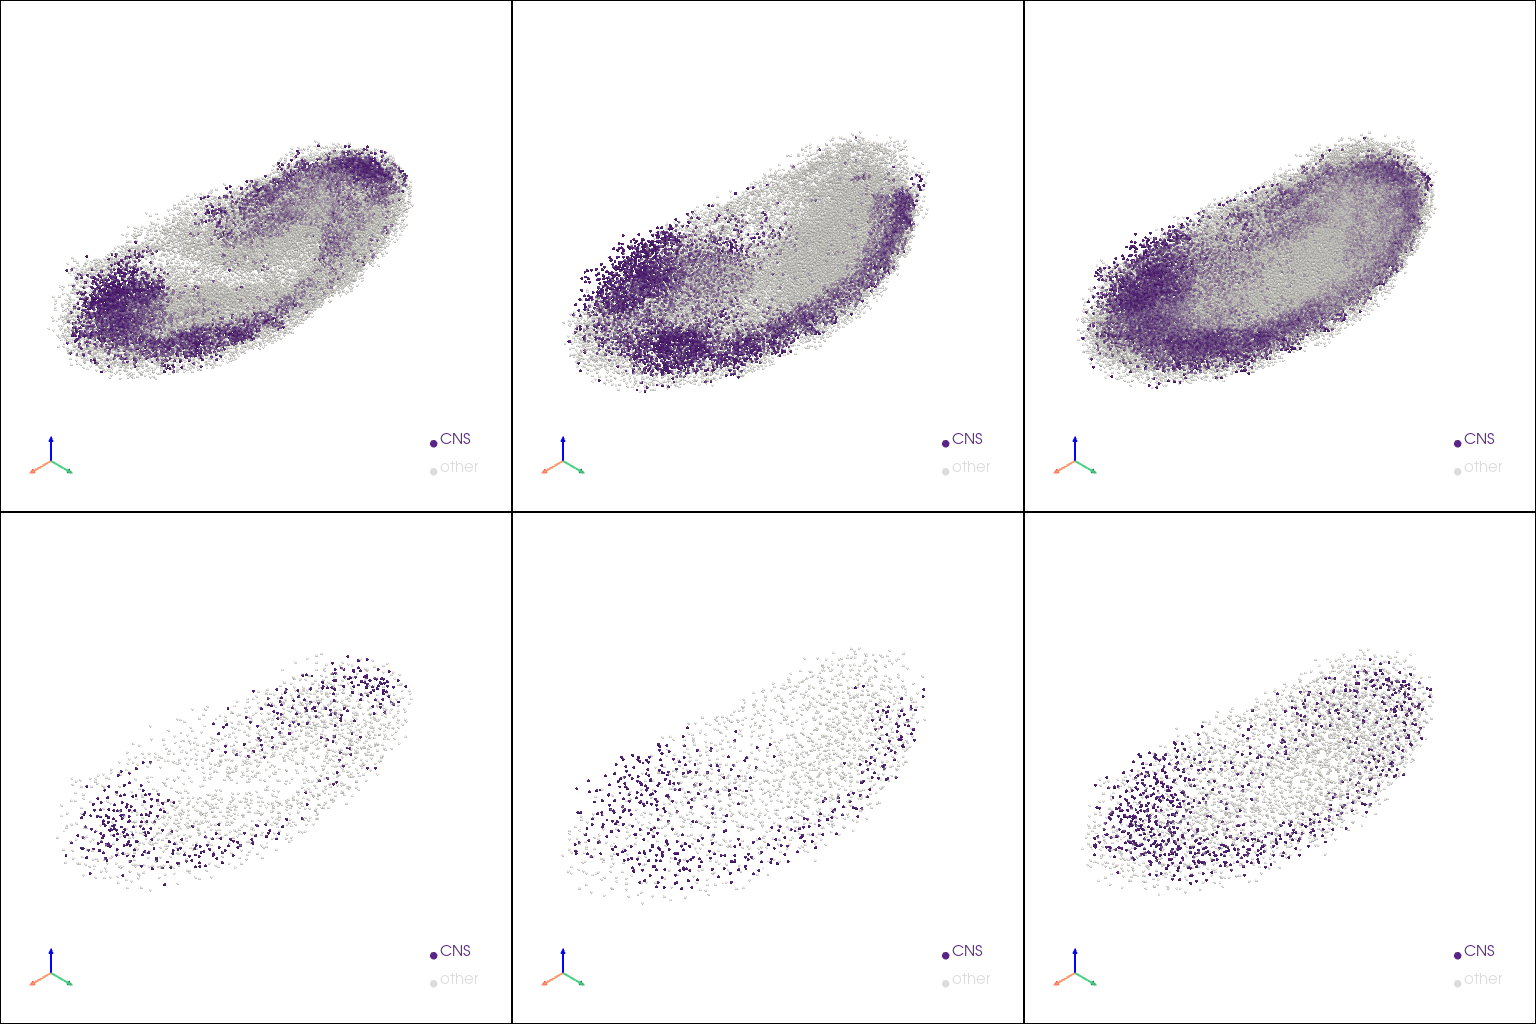

In [13]:
aligned_pcs_v = []
for pcs in [[stage1_aligned_pc.copy(), stage2_aligned_pc.copy()], [stage1_aligned_ref_pc.copy(), stage2_aligned_ref_pc.copy()]]:
    for pc in pcs:
        cns_label = np.asarray(pc.point_data["tissue"])
        cns_label[cns_label != "CNS"] = "other"
        st.tdr.add_model_labels(model=pc, labels=cns_label, key_added="check_alignment", where="point_data", inplace=True,
                                colormap={"CNS": "#5A2686", "other": "gainsboro"}, alphamap={"CNS": 1.0, "other": 0.5})
    pcs.append(st.tdr.collect_models(pcs.copy()))
    aligned_pcs_v.extend(pcs)

st.pl.three_d_multi_plot(
    model=st.tdr.collect_models(aligned_pcs_v),
    key="check_alignment",
    model_style="points",
    model_size=3,
    off_screen=False,
    shape=(2, 3),
    window_size=(512*3, 512*2),
    jupyter="static",
)

## Check that the alignment results at the cell level

In [14]:
cells_align_dict = stage1_aligned_adata.uns["latter_models_align"]
align_lines = st.tdr.construct_align_lines(
    model1_points=cells_align_dict["mapping_X"].copy(),
    model2_points=cells_align_dict["mapping_Y"].copy() + np.asarray([0, 0, - 300]),
    key_added="check_align", label="align_lines", color="gainsboro")

In [15]:
stage1_aligned_pc_v = stage1_aligned_pc.copy()
stage2_aligned_pc_v = stage2_aligned_pc.copy()
stage2_aligned_pc_v.points[:, 2] = stage2_aligned_pc_v.points[:, 2] - 300

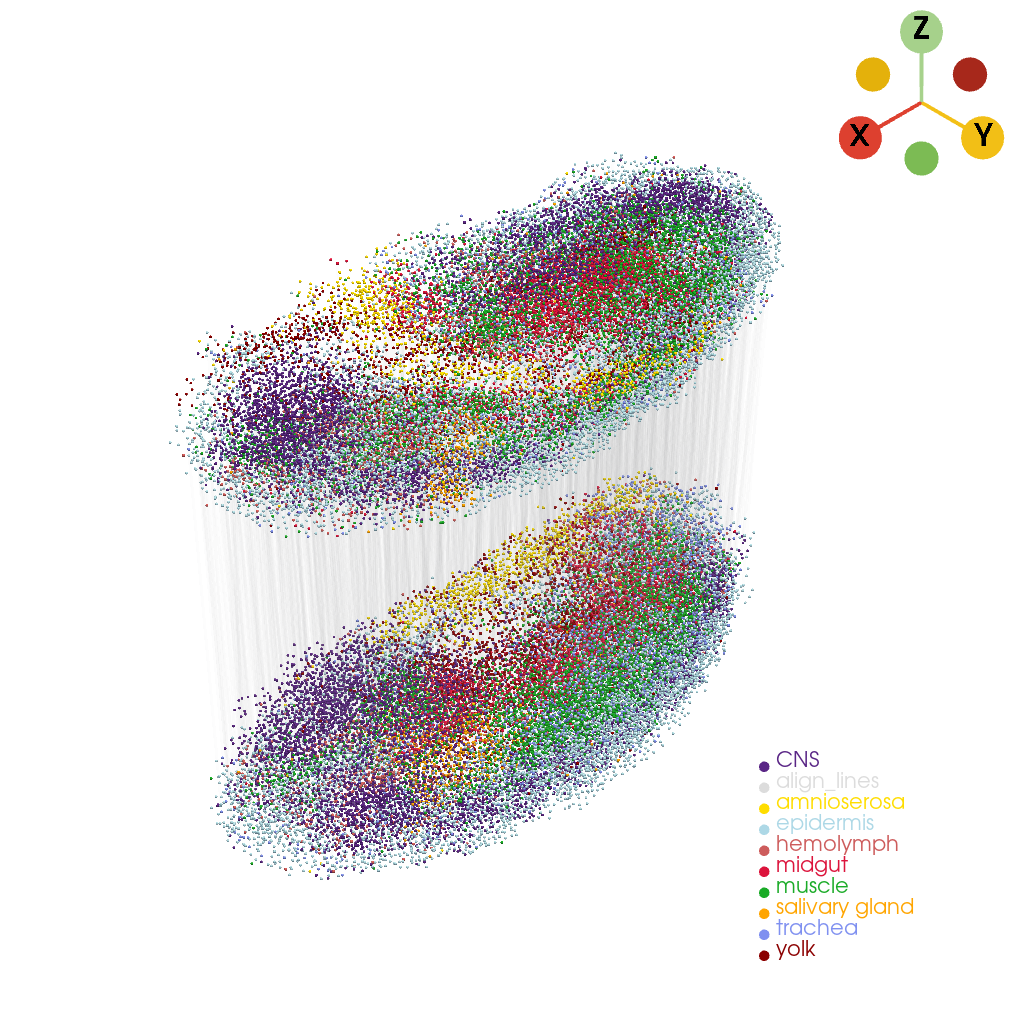

In [16]:
st.pl.three_d_plot(
    model=st.tdr.collect_models([align_lines, stage1_aligned_pc_v, stage2_aligned_pc_v]),
    key=["check_align", "tissue", "tissue"],
    opacity=[0.01, 1.0, 1.0],
    model_style=["wireframe", "points", "points"],
    model_size=3,
    off_screen=False,
    window_size=(1024, 1024),
    jupyter="static",
)